# Grover's Algorithm and Matched Filtering

This script demonstrates how Grover's algorithm can be used in detecting gravitational waves. We consider the first gravitational wave detection GW150914 and use Grover's algorithm to search through the template bank for waveforms that gives a matched-filter signal-to-noise ratio of greater than 12. 

On a quantum computer, Grover's algorithm offers a speed-up of $ \sqrt{M}$ speed-up where $M$ is the number of templates in the template bank (note that here $N$ denotes the number of frequency bins considered in the data, while $M$ is the number of templates in the bank, which is the opposite from the paper for now!).

In [1]:
# Import necessary packages
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from functools import partial

from pycbc.waveform import get_td_waveform
from pycbc.filter import matched_filter, make_frequency_series
from pycbc.types import TimeSeries, FrequencySeries

import time, os, h5py, multiprocessing

debug = False

# Set the random number generator seed 
np.random.seed(int(time.time()))

In [2]:
#plt.rcParams["font.family"] = "Times New Roman"
#plt.rcParams["font.family"] = "serif"
#plt.rcParams["mathtext.fontset"] = "dejavuserif"
matplotlib.rc('text', usetex = True)
matplotlib.rc('font', **{'family' : "sans-serif"})
params= {'text.latex.preamble' : [r'\usepackage{amsmath}']}
figsize=(8,6)

In [3]:
# Set the threshold SNR
SNR = 12.
# Load the data (GW150914) and the corresponding psd
Data = np.load('signal.npy')
psd = np.load('psd.npy')

The data is in the frequency domain. It is $28\,$s of strain data from the Hanford gravitational wave detector about the merger, sampled at $2048\,$Hz aftern being preprocessed with a high-pass filter at $20\,$Hz. Inverse Fourier transforming this gives the time-series plotted below:

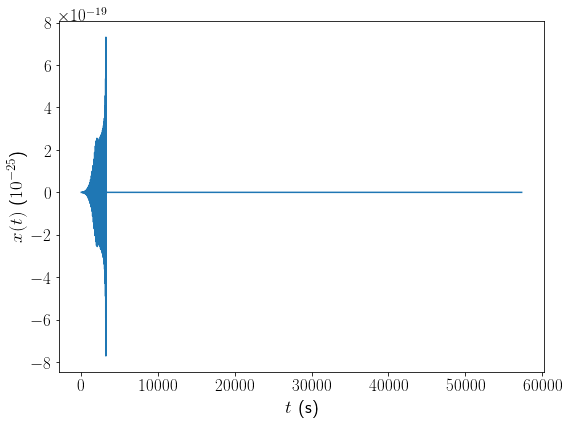

In [39]:
fig = plt.figure(figsize=figsize)
#plt.title('Figure 1')

waveform = get_td_waveform(approximant="IMRPhenomPv3",
                            mass1=35.6, mass2=30.6,
                            spin1z=0., spin2z=0.,
                            delta_t=1./2048, f_lower=20)
waveform = waveform[0]
waveform.resize(len(np.fft.irfft(Data)))

plt.plot(waveform)
#plt.plot(np.arange(len(np.fft.irfft(Data)))/2048., np.fft.irfft(Data)/1.e-25, lw=.2, color='black')
plt.xlabel(r'$t$ (s)')
plt.ylabel(r'$x(t)$ ($10^{-25}$)')
plt.savefig('plots/strain.png')
plt.tight_layout()
plt.show()

Can you see the signal? I sure can't. Let's see if matched filtering can.

In [5]:
# Qubits for templates
Mqubits = 9
# Qubits for Grover's
Pqubits = 7

In [6]:
# N is the number of data points
N = len(Data)
# Number of templates
M = int(2**(Mqubits))
# Number of states in ancillary register
P = int(2**(Pqubits))

In [7]:
# Generate indicies over time
n_inds = np.arange(N)
# Generate indicies over templates
m_inds = np.arange(M)
# Create indicies for each Grover's iteration
p_inds = np.arange(P)

In [8]:
def get_paras(M):
    '''
    Get mass/spins given index
    ''' 
    
    bank_file = 'H1L1-BANK2HDF_SPLITBANK_BANK0_INJECTIONS-1134450017-1202400.hdf'
    full_bank = h5py.File(bank_file,'r')

    bank_size = full_bank['mass1'].size
    
    if bank_size>M:
        indexes = np.arange(bank_size)[::int(bank_size//M)][:M]
    else:
        indexes = np.arange(bank_size)
    
    bank = {}
    bank['mass1'] = np.array(full_bank['mass1'][indexes])    
    bank['mass2'] = np.array(full_bank['mass2'][indexes]) 
    bank['spin1z'] = np.array(full_bank['spin1z'][indexes]) 
    bank['spin2z'] = np.array(full_bank['spin2z'][indexes])   

    return bank

In [9]:
paras = get_paras(M)

The number of templates used in this example, $M$, are taken from a bank of 49,994 templates. The selected templates that are taken from the bigger bank are equally spaced. Each has a different combination of mass and spin for each of the two merging black holes. The distribution of masses and spins are shown in the plots below:

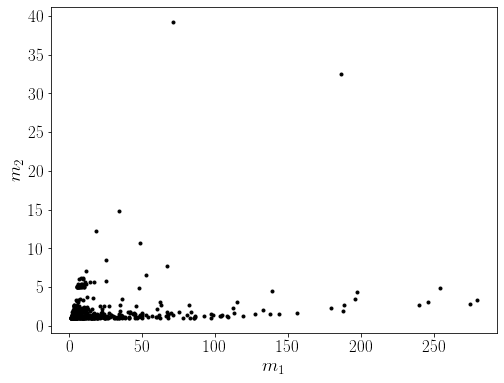

In [10]:
fig = plt.figure(figsize=figsize)
#plt.title('Figure 2')
plt.scatter(paras['mass1'], paras['mass2'], color='black', marker='.')
plt.xlabel(r'$m_{1}$')
plt.ylabel(r'$m_{2}$')
plt.show()

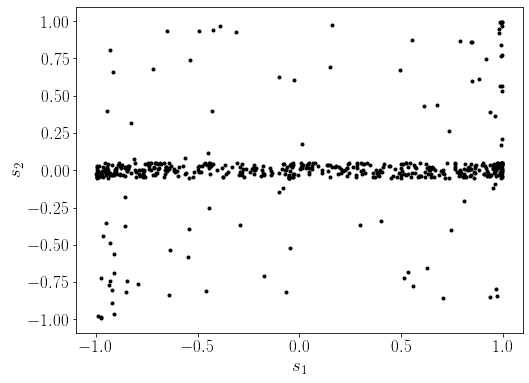

In [11]:
fig = plt.figure(figsize=figsize)
plt.scatter(paras['spin1z'], paras['spin2z'], color='black', marker='.')
#plt.title('Figure 3')
plt.xlabel(r'$s_{1}$')
plt.ylabel(r'$s_{2}$')
plt.show()

First let us make the state:

$$ |\psi_{\text{ini}}⟩ = \frac{1}{\sqrt{MN}}\sum^{M-1}_{m=0}\sum^{N-1}_{n=0}|m⟩|n⟩. $$

This state is what the template information will be stored in. Let us also define:

$$ |i⟩ = \frac{1}{\sqrt{M}}\sum^{M-1}_{m=0}|m⟩. $$

This state has a basis state that corresponds to the indexes of each template. We perform operation $\hat{k}_{1}$ on this state to give a state that represent the template waveforms in the frequency domanin $|T⟩$:

$$ |i⟩\otimes |T⟩ = \hat{k}_{1}(|i⟩\otimes |\psi_{\text{ini}}⟩). $$

Similarly the data is loaded into a state represented by $|D⟩$.

In [12]:
# Initiating the index states
index_states = np.ones((M))/np.sqrt(M)

In [13]:
def SNR_given_index(data, psd, dt, df, paras):
    '''
    Perform matched filtering on some data
    given the psd, delta f (df), delta t (dt)
    and parameters to make a waveform 
    (mass1, mass2, spin1z, spin2z, f low).
    '''
    
    m1,m2,s1,s2,fl = paras
    N = len(data)
    waveform_ = get_td_waveform(approximant="IMRPhenomPv3",
                                mass1=m1, mass2=m2,
                                spin1z=s1, spin2z=s2,
                                delta_t=dt, f_lower=fl)
    waveform_[0].resize(int(2*(N - 1)))
    template_ = waveform_[0].cyclic_time_shift(waveform_[0].start_time)
    template = np.array(make_frequency_series(TimeSeries(template_,delta_t=dt)))
    SNR = matched_filter(FrequencySeries(template, delta_f=df),
                FrequencySeries(data, delta_f=df),
                FrequencySeries(psd, delta_f=df))
    SNR = np.array(SNR.crop(8, 4))
    return np.max(np.abs(SNR))

In [14]:
def k_12(index_states, Templates, Data, ini_w, dt=1./2048, f_low=20., threshold=12):
    '''
    Make wavforms from index
    ''' 
    
    M = index_states.shape[0]
    N = len(Data)
    bank_file = 'H1L1-BANK2HDF_SPLITBANK_BANK0_INJECTIONS-1134450017-1202400.hdf'
    full_bank = h5py.File(bank_file,'r')
    
    bank_size = full_bank['mass1'].size
    
    psd = np.load('psd.npy')
    freqs = np.fft.fftfreq(2*(N-1))*1./dt
    df = np.abs(freqs[1]-freqs[0])
    
    if bank_size>M:
        indexes = np.arange(bank_size)[::int(bank_size//M)][:M]
    else:
        indexes = np.arange(bank_size)
        
    m1s = full_bank['mass1'][indexes]
    m2s = full_bank['mass2'][indexes]
    s1s = full_bank['spin1z'][indexes]
    s2s = full_bank['spin2z'][indexes]    
    fls = full_bank['f_lower'][indexes]

    paras = iter(np.array([m1s,m2s,s1s,s2s,fls]).T)
    
    pool = multiprocessing.Pool(multiprocessing.cpu_count())
    func = partial(SNR_given_index, Data, psd, dt, df)
    SNRs = np.array(pool.map(func, paras))
    pool.close()
    w = np.where(SNRs>=threshold,-1.,1.)

    if len(w)<M:
        w = np.pad(w,(0,M-len(w)),constant_values=1.).astype(float)
    w*=1./np.sqrt(M)
    return index_states, Templates, Data, w

Grover's algorithm is applied after matched filtering is to all templates. On a quantum computer, this can be done in parallel to give an equal amplitude state $|w⟩$ of length $M$ but any state that corresponds to the index of a template that meets the criteria of $SNR>12$ has a phase-flip of -1. $|w⟩$ is made by applying $\hat{k}_{2}$:

$$|i⟩\otimes|T⟩\otimes|D⟩\otimes|w⟩ = \hat{k}_{2}(|i⟩\otimes|T⟩\otimes|D⟩\otimes|0⟩^{\times 2^{M}}).$$

However, for this classical illustration it is convinient for us to combine $\hat{k}_{1}$ and $\hat{k}_{2}$ into $\hat{k}_{12}$ and omit using the $|\psi_{\text{ini}}⟩$ and $|T⟩$ states (for memory reasons):

$$|i⟩\otimes|T⟩\otimes|D⟩\otimes|w⟩ = \hat{k}_{12}(|i⟩\otimes|\psi_{\text{ini}}⟩\otimes|D⟩\otimes|0⟩^{\times 2^{M}}).$$

In [15]:
# Define the psi ini state (currently not used)
psi_ini = None # Just used as a placeholder
# Apply k12 to the states
index_states, Templates, Data, w = k_12(index_states, psi_ini, Data, np.identity(M)[0], threshold=SNR)

It is this state $|w⟩$ that we are interested in now. It should show states with equal amplitudes, but a minus infront of states corresponding to indexes of matching templates when printed below:

In [16]:
print(w)

[ 0.04419417  0.04419417  0.04419417  0.04419417  0.04419417  0.04419417
  0.04419417  0.04419417  0.04419417  0.04419417  0.04419417  0.04419417
  0.04419417  0.04419417  0.04419417  0.04419417  0.04419417  0.04419417
  0.04419417  0.04419417  0.04419417  0.04419417  0.04419417  0.04419417
  0.04419417  0.04419417  0.04419417  0.04419417  0.04419417  0.04419417
  0.04419417  0.04419417  0.04419417  0.04419417  0.04419417  0.04419417
  0.04419417  0.04419417  0.04419417  0.04419417  0.04419417  0.04419417
  0.04419417  0.04419417  0.04419417  0.04419417  0.04419417  0.04419417
  0.04419417  0.04419417  0.04419417  0.04419417  0.04419417  0.04419417
  0.04419417  0.04419417  0.04419417  0.04419417  0.04419417  0.04419417
  0.04419417  0.04419417  0.04419417  0.04419417  0.04419417  0.04419417
  0.04419417  0.04419417  0.04419417  0.04419417  0.04419417  0.04419417
  0.04419417  0.04419417  0.04419417  0.04419417  0.04419417  0.04419417
  0.04419417  0.04419417  0.04419417  0.04419417  0

Now we can apply Grover's algorithm to find these matching states. Let's initialise the state:

$$ |\psi_{0}⟩ = \frac{1}{\sqrt{PM}}\sum^{P-1}_{p=0}\sum^{M-1}_{m=0}|p⟩|m⟩. $$

In [17]:
# Initialising joint state psi_0 which we apply Grover's algorithm over given w
psi_0 = np.ones((M,P))/np.sqrt(M*P)

The first part of Grover's algorithm is then applied as follows:

1. Create operator $\hat{U}_{w}=\mathcal{I}-2|w⟩⟨w|$ where $w$ is the matrix position corresponding to the matching templates. This operator has the property:

$$ \hat{U}_{w} |x⟩ = -|x⟩ \text{ if } x=w, $$
$$ \hat{U}_{w} |x⟩ = |x⟩ \text{ if } x\ne w.\ \ \$$

2. Initiate superposition:

$$ |s⟩ = \frac{1}{\sqrt{M}}\sum^{M-1}_{x=0}|x⟩, $$

assuming that every template is equally likely to have the correct template without any more prior knowledge.

3. Create the Grover diffusion operator $\hat{U}_{s}=2|s⟩⟨s|-\mathcal{I}$.

4. Apply $\hat{U}_{w}$ then $\hat{U}_{s}$ to $|\psi_{0}⟩$ $p$ times to each state in $P$ ($p=\{0,1,...P-1\}$).

In [18]:
def U_w(w):
    '''
    Defines the matrix operation applied to psi_0 given w.
    This operator flips the phase of a state that corresponds to w.
    '''
    M = len(w)
    return np.sqrt(M)*np.multiply(np.eye(M),w)

In [19]:
def U_s(w):
    '''
    Defines the matrix operation applied to psi_0 given w.
    This is "Grovers diffusion operator". 
    '''
    M = len(w)
    s_i = np.array([np.ones(M)/np.sqrt(M)]).T
    return 2*np.outer(s_i,s_i)-np.eye(M)

In [20]:
def Grovers1(w, psi_0):
    '''
    This corresponds to the first part of Grovers algorithm.
    Here operators U_w and U_s are applied to psi_0 "p" times for each of the P states.
    '''
    M, P = psi_0.shape[0], psi_0.shape[1]
    psi_1 = np.zeros((M,P))
    for p in np.arange(P):
        psi_1[:,p] = np.dot(np.linalg.matrix_power(np.matmul(U_s(w),U_w(w)),p),psi_0[:,p])
    return psi_1

Now we apply Grover's algorithm itterably to this state such that:

$$ |\psi_{1}⟩ = \hat{C}_{G}|\psi_{0}⟩, $$

where $\hat{C}_{G}|p⟩\otimes |m⟩\rightarrow |p⟩\otimes (\hat{G})^{p}|m⟩$,

and $\hat{G}=\hat{U_{s}}\hat{U_{w}}$.

In [21]:
# Apply the first part of Grover's algorithm
psi_1 = Grovers1(w,psi_0)

We can see what this operation does to $|\psi_{0}⟩$ in the plot bellow:

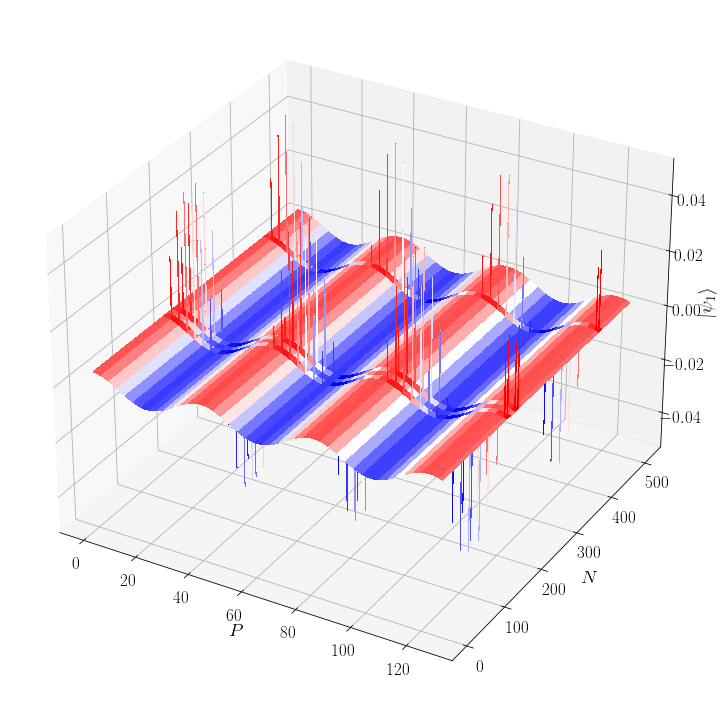

In [22]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

X, Y = np.meshgrid(p_inds, m_inds)
Z=psi_1
fig = plt.figure(figsize=(14,10))
ax = fig.gca(projection='3d')
#ax.set_title('Figure 4')

surf = ax.plot_surface(X, Y, Z, cmap=cm.bwr,
                       linewidth=0, antialiased=False)

ax.set_xlabel(r'$P$')
#ax.set_ylabel(r'$M$')
ax.set_ylabel(r'$N$')
ax.set_zlabel(r'$|\psi_{1}\rangle$')

plt.tight_layout()
plt.savefig('plots/amplitudes.png')

plt.show()

We see the amplitudes of states $\psi_{1}$ numbering $P\times M$. Where the amplitudes of the states around correct solutions are much greater than the incorrect solutions. The incorrect solutions also exhibit a sinusoidal pattern. 

It is the frequency $f$ of this sinusoid that we wish to determine, as it is related to the number of correct template matches $k$ by:

$$ k = M\sin^{2}\frac{f\pi}{P}. $$

Determining phase/frequency information from amplitudes of states requires a *quantum fourier transform*.

### Quantum Fourier Transform

The *quantum fourier transform* is much the same as it's classical counterpart but is performed on amplitude/phase information stored on the states of qubits. It transfers information stored in amplitudes in quantum states into phase information. There also exists the inverse quantum fourier transform for the reverse opperation.

The quantum fourier transform acting on state $|p⟩$ gives:

$$ \mathrm{QFT}:|x⟩ \mapsto \frac{1}{\sqrt{K}}\sum^{K-1}_{k=0}e^{2\pi i\frac{kx}{K}}|k⟩. $$

The inverse quantum fourier transform is applied across the ancillary qubits the recover the phase information from the sinusoidal behaviour in the states shown in the graph above. This requires creating a $QFT^{-1}$ operator of size $P\times P$, which we will call $\hat{F}_{P}$ as done below:

In [23]:
def IQFT(P):
    '''
    Constructing the inverse fourier transform of size PxP.
    '''
    return np.round(
            np.array([[(np.exp(-2.*i*j*1j*np.pi/P)) 
                   for j in np.arange(P)] 
                    for i in np.arange(P)]),1)*1./np.sqrt(P)

In [24]:
def Grovers2(psi_1):
    '''
    The seconds part of Grovers algorithm. 
    Here we apply the inverse quantum Fourier transform to psi_2.
    '''
    M, P = psi_1.shape[0], psi_1.shape[1]
    return np.dot(IQFT(P),psi_1.T)

Applying this across the ancillary states in $|\psi_{1}⟩$:

$$ \psi_{2} = \hat{F}_{P}\psi_{1}. $$

In [25]:
# We apply the second part of Grover's algoirthm to state psi_1
psi_2 = Grovers2(psi_1)

This operation changes $|\psi_{1}⟩$ to the states in the plot bellow (note that I now show the state probability and not the amplitudes in the $z$ axis): 

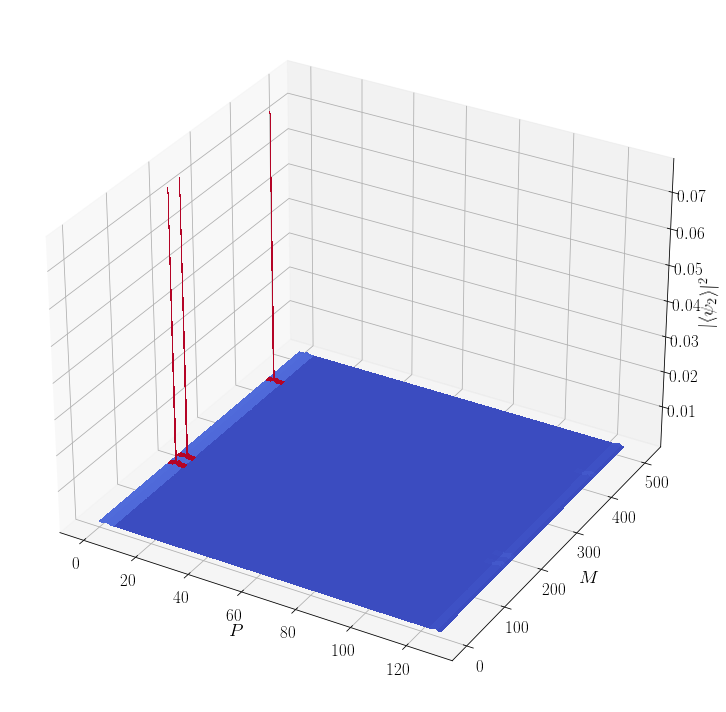

In [26]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from matplotlib import cm

X, Y = np.meshgrid(p_inds, m_inds)
Z=np.absolute(psi_2).T**2
fig = plt.figure(figsize=(14,10))
ax = fig.gca(projection='3d')
#ax.set_title('Figure 5')

surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax.set_xlabel(r'$P$')
ax.set_ylabel(r'$M$')
ax.set_zlabel(r'$|\langle\psi_{2}\rangle|^{2}$')
plt.tight_layout()
plt.savefig('plots/IQFT.png')
plt.show()

The probabilities $|\psi_{2}|^{2}$ are seen over ancillary and template states. There are two peaks, corresponing to $f$ and $P-f$. Measuring the ancillary state will likely acquire one or the other. These peaks also correspond to the positions of matching templates, and so measuring the template qubits likely recovers a correct position of a template.

From knowing $f$ or $P-f$ we can work out the number of matched templates $k$ with the relation:

$$ k = M\sin^{2}\frac{f\pi}{P}. $$

Doing this gives the number of matching templates for this example as:

In [27]:
# Measure each of the qubits corresponding to template states M and period states P
measurement = np.unravel_index(np.argmax(np.absolute(psi_2)**2), psi_2.shape)

# The resulting state measured from the P qubits tells us about the number of matching templates
P_measured = measurement[0]

# The result from measuring P corresponds to the frequency of the sinesoid shown in Figure 3
N_templates = int(np.round(M*np.sin(P_measured*np.pi/P)**2))

print('Number of matching templates:',N_templates)

Number of matching templates: 3


Is this number greater than 0? Do we have any matching templates? If so, we may wish to find a corresponding matching template. To do this we need to find out the optimum number of Grover's applications to apply. This can easily be found from knowing the number of matching templates:

$$ p_{\text{opt}} \approx \frac{\pi}{4}\sqrt{\frac{M}{k}}. $$

In [28]:
# Calculate the optimum number of Grover's applications to find a 
# matching template.
opt_p = int(np.round((np.pi/4.)* np.sqrt(M/N_templates)))

print('Optimum number of Grover applications:',opt_p)

Optimum number of Grover applications: 10


Now we can just apply Grover's algorithm $p_{\text{opt}}$ times to $\frac{1}{\sqrt{M}}\sum_{i=0}^{M-1}|m⟩$ to result in a state with amplitudes maximally amplified corresponding to matching states:

In [29]:
psi_0_ = np.ones((M))/np.sqrt(M)
psi_1_opt = np.dot(np.linalg.matrix_power(np.matmul(U_s(w),U_w(w)),opt_p),psi_0_)

Now lets see how the maximum state probability changes over applications of Grover's iterations. This is plotted below along with a line indicating the determined optimal number of applications:

In [30]:
probs_out = []
for p in np.arange(4*opt_p+1):
    psi_1_ = np.dot(np.linalg.matrix_power(np.matmul(U_s(w),U_w(w)),p),psi_0_)
    probs_out.append(np.max(np.abs(psi_1_)**2))

probs_out = np.array(probs_out)

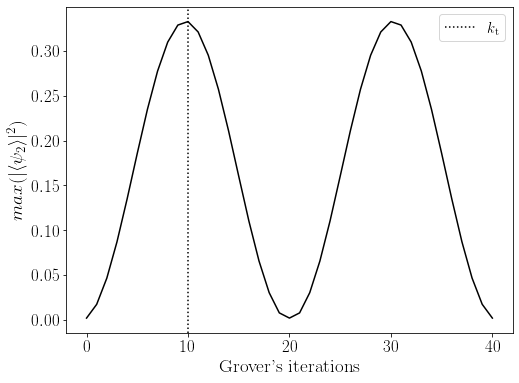

In [31]:
#plt.title('Figure 6')
fig = plt.figure(figsize=figsize)
plt.plot(probs_out, color='black')
plt.xlabel(r"\textrm{Grover's iterations}")
plt.ylabel(r'$max(|\langle\psi_{2}\rangle|^{2})$')#Probability of max probability state')
plt.axvline(opt_p, ls=':', color='black', label=r'$k_{\mathrm{t}}$')
#plt.axvline(opt_p, ls=':', color='black', label=r'$p_{opt}$')
plt.legend(fontsize=15)
plt.savefig('plots/popt.png')
plt.show()

The optimal number of Grover's applications corresponds (approximately, given the number of templates is high) to the maximum probability over iterations. We can see what the template states look like given the $p_{\text{opt}}$ iterations have been applied:

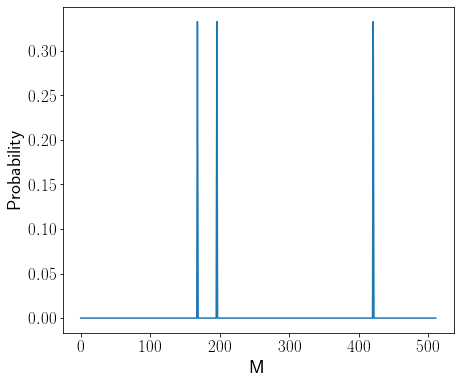

In [32]:
#plt.title('Figure 7')
fig = plt.figure(figsize=(7,6))
plt.plot(np.abs(psi_1_opt)**2)
plt.xlabel('M')
plt.ylabel('Probability')
plt.show()

The high probability states correspond to the indicies of matching templates. They should have equal probability and approximately sum to 1.

Let's pick out these states with amplified amplitudes and see what masses and spins they correspond to in the template bank.

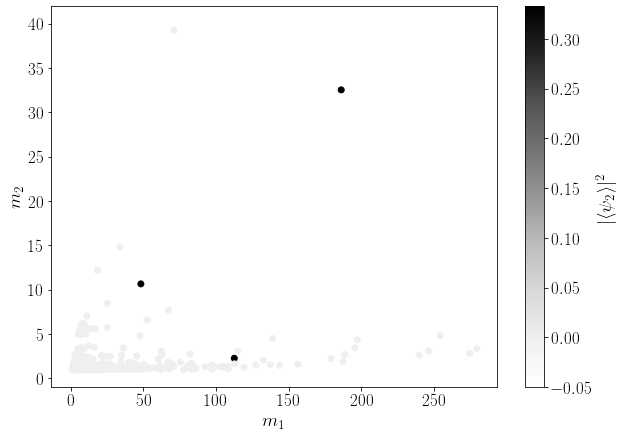

In [33]:
fig = plt.figure(figsize=(10,7))
ax = plt.subplot(111)
#plt.title('Figure 8')
sc=ax.scatter(np.append(paras['mass1'], 0.), np.append(paras['mass2'], 40.), c=np.append(np.abs(psi_1_opt)**2, -.05), marker='o', lw=1, cmap=cm.Greys)
cb = plt.colorbar(sc, ax=[ax], label=r'$|\langle\psi_{2}\rangle|^{2}$')
plt.xlabel(r'$m_{1}$')
plt.ylabel(r'$m_{2}$')
plt.savefig('plots/mass_dists.png')
plt.show()

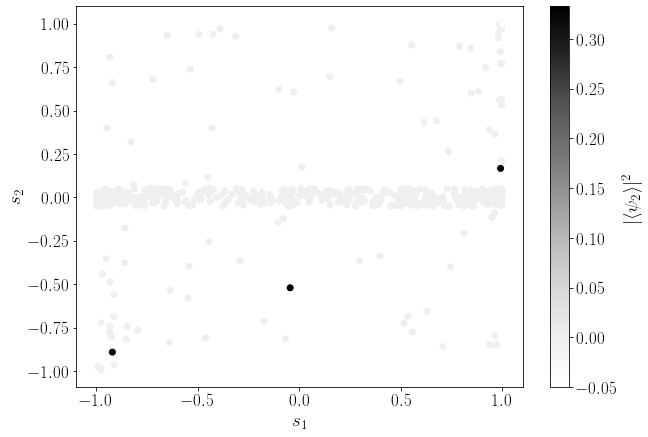

In [34]:
fig = plt.figure(figsize=(10,7))
ax = plt.subplot(111)
#plt.title('Figure 8')
sc=ax.scatter(np.append(paras['spin1z'], 1.), np.append(paras['spin2z'], 1.), c=np.append(np.abs(psi_1_opt)**2, -.05), marker='o', lw=1, cmap=cm.Greys)
cb = plt.colorbar(sc, ax=[ax], label=r'$|\langle\psi_{2}\rangle|^{2}$')
plt.xlabel(r'$s_{1}$')
plt.ylabel(r'$s_{2}$')
plt.savefig('plots/spin_dists.png')
plt.show()

In [35]:
Data = np.load('noise.npy')
# N is the number of data points
N = len(Data)

In [36]:
# Initiating the joint states across float, time and template qubits
index_states = np.ones((M))/np.sqrt(M)

In [37]:
index_states, psi_ini, Data, w = k_12(index_states, psi_ini, Data, np.identity(M)[0], threshold=SNR)

Process ForkPoolWorker-7:
Traceback (most recent call last):
Process ForkPoolWorker-8:
  File "/home/fergus/src/Anaconda/anaconda3/envs/ligo-py36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/fergus/src/Anaconda/anaconda3/envs/ligo-py36/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/fergus/src/Anaconda/anaconda3/envs/ligo-py36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/fergus/src/Anaconda/anaconda3/envs/ligo-py36/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/fergus/src/Anaconda/anaconda3/envs/ligo-py36/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/home/fergus/src/Anaconda/anaconda3/envs/ligo-py36/lib/python3.6/multiprocessing/pool.py", line 44, 

KeyboardInterrupt: 

  File "/home/fergus/src/Anaconda/anaconda3/envs/ligo-py36/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/home/fergus/src/Anaconda/anaconda3/envs/ligo-py36/lib/python3.6/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "<ipython-input-13-684081c74fb4>", line 14, in SNR_given_index
    delta_t=dt, f_lower=fl)
  File "/home/fergus/src/Anaconda/anaconda3/envs/ligo-py36/lib/python3.6/site-packages/pycbc/waveform/waveform.py", line 470, in get_td_waveform
    return wav_gen(**input_params)
  File "/home/fergus/src/Anaconda/anaconda3/envs/ligo-py36/lib/python3.6/site-packages/pycbc/waveform/waveform.py", line 155, in _lalsim_td_waveform
    _lalsim_enum[p['approximant']])
KeyboardInterrupt
Process ForkPoolWorker-5:
Traceback (most recent call last):
  File "/home/fergus/src/Anaconda/anaconda3/envs/ligo-py36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/h

In [ ]:
# Initialising joint state psi_0 which we apply Grover's algorithm over given w
psi_0_n = np.ones((M,P))/np.sqrt(M*P)
# Apply the first part of Grover's algorithm
psi_1_n = Grovers1(w,psi_0_n)
# We apply the second part of Grover's algoirthm to state psi_1
psi_2_n = Grovers2(psi_1_n)

In [ ]:
# Measure each of the qubits corresponding to template states M and period states P
measurement_n = np.unravel_index(np.argmax(np.absolute(psi_2_n)**2), psi_2_n.shape)

# The resulting state measured from the P qubits tells us about the number of matching templates
P_measured_n = measurement_n[0]

In [ ]:
# The result from measuring P corresponds to the frequency of the sinesoid shown in Figure 3
N_templates_n = int(np.round(M*np.sin(P_measured_n*np.pi/P)**2))

In [ ]:
print('Number of matching templates given noise:',N_templates_n)